In [1]:
from model import DaCluDeK

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [70]:
defined_keywords = {
    'business': ['business'],
    'entertainment': ['entertainment'],
    'politics': ['politics'],
    'sport': ['sport'],
    'tech': ['technology']
}
documents_df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()#[:100]
labels = documents_df['class_name'].tolist()#[:100]

doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20, dimensionality_reduction_n_components=2)
doc2vec_model.fit()

In [4]:
transformer_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True, dimensionality_reduction_n_components=2, dimensionality_reduction_model_name='PCA')
transformer_model.fit()

In [32]:
def visualise_embeddings_for_model(model):
    embedded_documents = model.encode_documents(documents)

    # -- Document Embeddings
    embeddings_df = pd.DataFrame(embedded_documents, columns=['x', 'y'])
    embeddings_df['label'] = labels

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Document Embeddings | {model.embedding_model_name}', fontsize=20, fontweight='bold')

    score_df = model.score(documents, labels)
    fig.text(x=0.5, y=0.91, s=f'Accuracy: {score_df["accuracy"].iloc[0]:.2f} | Precision: {score_df["precision"].iloc[0]:.2f} | Recall: {score_df["recall"].iloc[0]:.2f} | F1: {score_df["f1"].iloc[0]:.2f}', fontsize=14, ha='center')
    fig.tight_layout(pad=3.0)

    colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple']

    for class_name, color in zip(model.defined_keywords.keys(), colors):
        x = embeddings_df[embeddings_df['label'] == class_name]['x']
        y = embeddings_df[embeddings_df['label'] == class_name]['y']

        ax[0].scatter(x, y, marker='o', s=30, c=color, label=class_name, linewidth=1, edgecolors='white')
    ax[0].set_title('True Labels', fontsize=16, fontweight='bold')

    # -- Predicted Labels
    y_pred = model.predict(documents)['class_name'].tolist()
    predictions_df = pd.DataFrame(embedded_documents, columns=['x', 'y'])
    predictions_df['label'] = labels
    predictions_df['predicted'] = y_pred

    for class_name, color in zip(model.defined_keywords.keys(), colors):
        x = predictions_df[predictions_df['predicted'] == class_name]['x']
        y = predictions_df[predictions_df['predicted'] == class_name]['y']

        ax[1].scatter(x, y, marker='o', s=30, c=color, label=class_name, linewidth=1, edgecolors='white')
    ax[1].set_title('Predicted Labels', fontsize=16, fontweight='bold')

    # -- Class Centroids
    for j in range(2):
        for i, (class_name, centroid) in enumerate(model.class_centroids.items()):
            ax[j].scatter(centroid[0], centroid[1], marker='x', s=100, c=colors[i], label=class_name, linewidth=3)

            offset_x = len(class_name) * -0.0028
            offset_y = 0.015
            ax[j].text(centroid[0] + offset_x, centroid[1] + offset_y, class_name, fontsize=12, color=colors[i], fontweight='bold', backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='white', pad=0.4, alpha=0.7, boxstyle='round'))
    
    # -- Class Keywords Embeddings
    embedded_keywords = model.encode_keywords()
    
    for j in range(2):
        for i, (class_name, embeddings) in enumerate(embedded_keywords.items()):
            single_embedding = np.mean(embeddings, axis=0)
            ax[j].scatter(single_embedding[0], single_embedding[1], marker='o', s=80, c=colors[i], label=class_name, linewidth=2, edgecolors='white')

            annotation_text = str(model.defined_keywords[class_name])[:20]
            offset_x = len(annotation_text) * -0.001
            offset_y = 0.01
            ax[j].text(single_embedding[0] + offset_x, single_embedding[1] + offset_y, annotation_text, fontsize=6, color=colors[i], fontweight='bold', backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='white', pad=0.2, alpha=0.7, boxstyle='round'))

    fig.savefig(f'../figures/{model.embedding_model_name}_document_embeddings.png', dpi=300)

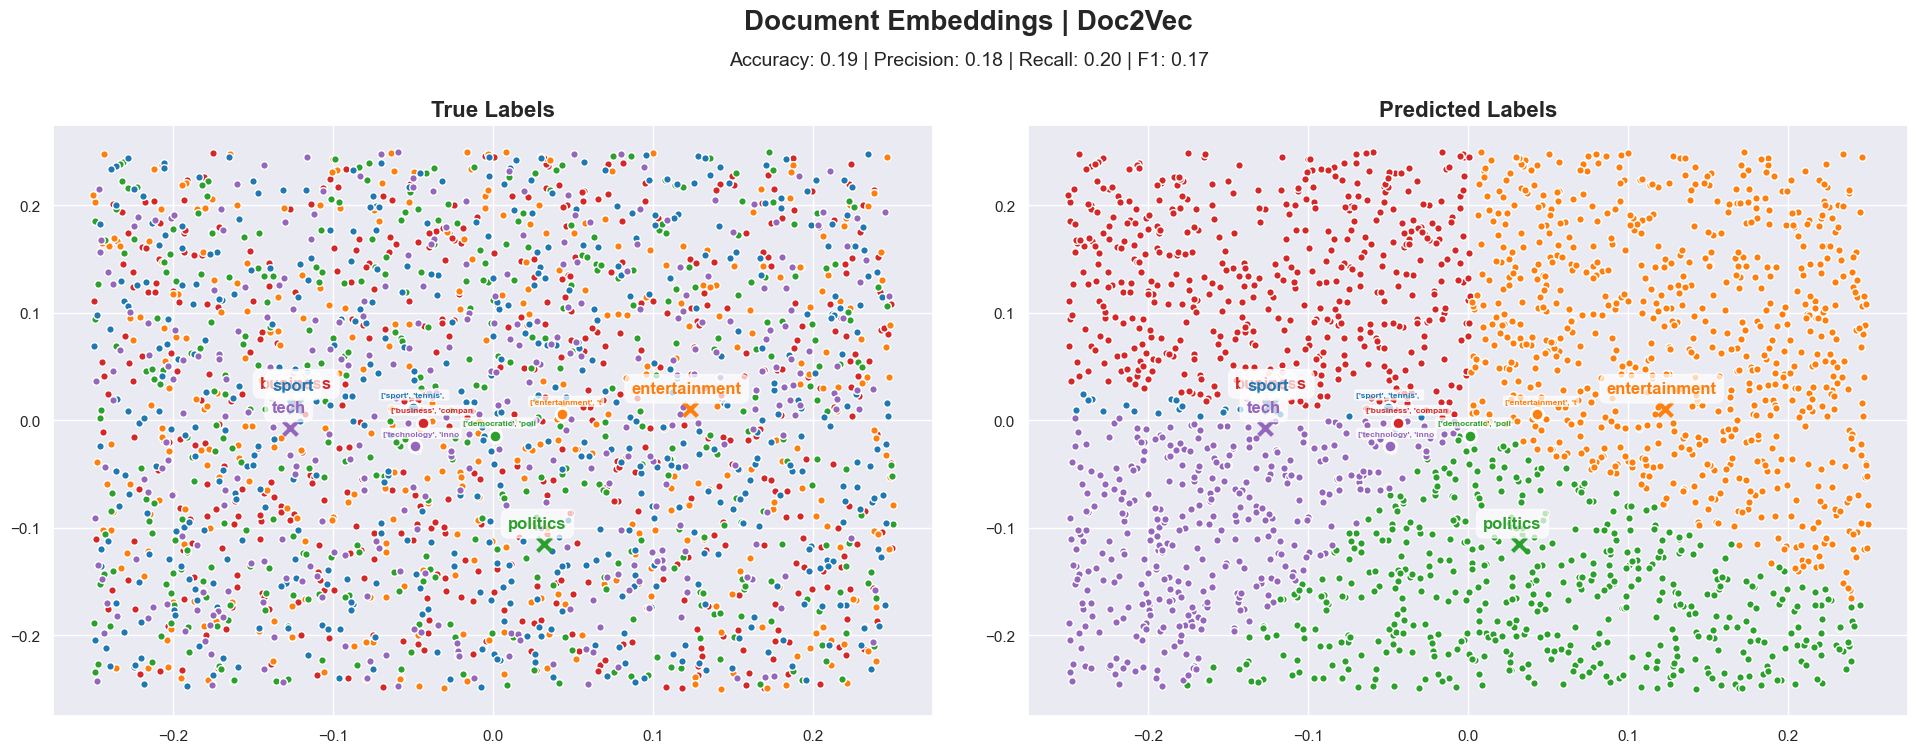

In [33]:
visualise_embeddings_for_model(doc2vec_model)

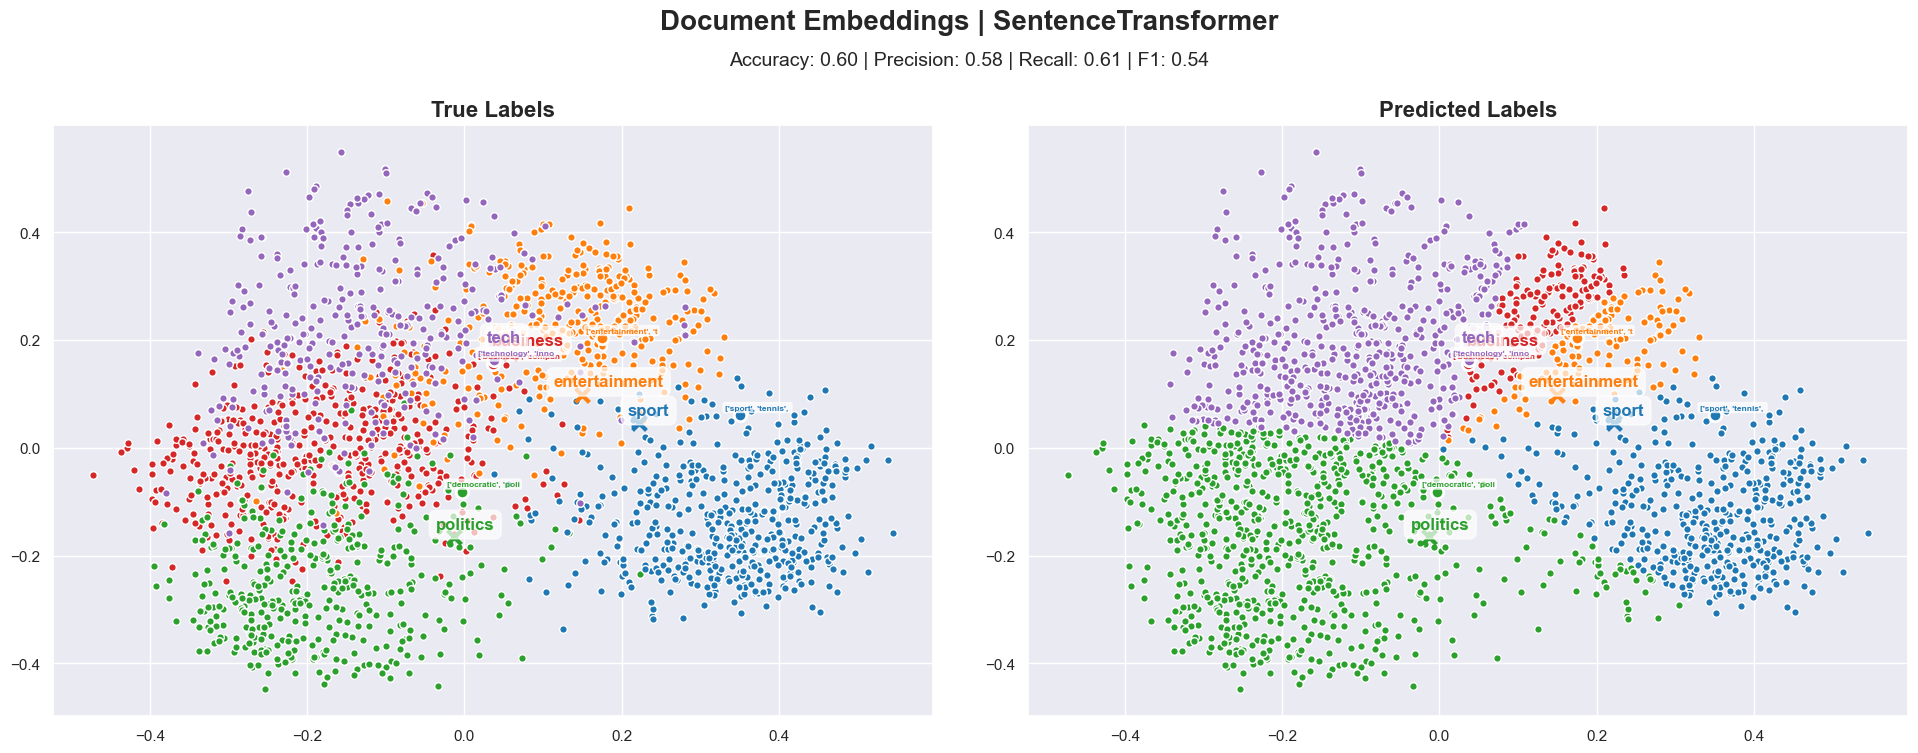

In [34]:
visualise_embeddings_for_model(transformer_model)

In [78]:
def get_centered_words_by_class(model):
    embedded_documents = model.encode_documents(documents)

    centered_documents_by_class = {}

    # Find the center of each class
    for class_name in transformer_model.defined_keywords.keys():
        centered_documents_by_class[class_name] = []

    for i, (document, label) in enumerate(zip(embedded_documents, labels)):
        centered_documents_by_class[label].append(document)

    for class_name, docs in centered_documents_by_class.items():
        centered_documents_by_class[class_name] = np.mean(docs, axis=0)

    # Find the nearest document to each class center
    nearest_documents_by_class = {}

    for class_name in model.defined_keywords.keys():
        nearest_documents_by_class[class_name] = []

    for i, (document, label) in enumerate(zip(embedded_documents, labels)):
        distance_to_center = np.linalg.norm(document - centered_documents_by_class[label])
        nearest_documents_by_class[label].append((distance_to_center, i, documents_df['document'].iloc[i]))

    for class_name, docs in nearest_documents_by_class.items():
        nearest_documents_by_class[class_name] = sorted(docs, key=lambda x: x[0])[0][2]

    # For each class, find the token in the nearest document that is closest to the class center
    nearest_keywords_by_class = {}

    for class_name in nearest_documents_by_class.keys():
        sentence = nearest_documents_by_class[class_name]
        tokens = sentence.split(' ')

        encoded_tokens = model.encode_documents(tokens)

        # Compute distance to class center for each token
        distances_to_center = []

        for token, encoded_token in zip(tokens, encoded_tokens):
            distance_to_center = np.linalg.norm(encoded_token - centered_documents_by_class[class_name])
            distances_to_center.append((distance_to_center, token))

        # Find the token closest to the class center
        nearest_keywords_by_class[class_name] = sorted(distances_to_center, key=lambda x: x[0])[0][1]

    return embedded_documents, centered_documents_by_class, nearest_documents_by_class, nearest_keywords_by_class

In [72]:
embedded_documents, centered_documents_by_class, nearest_documents_by_class, nearest_keywords_by_class = get_centered_words_by_class(transformer_model)

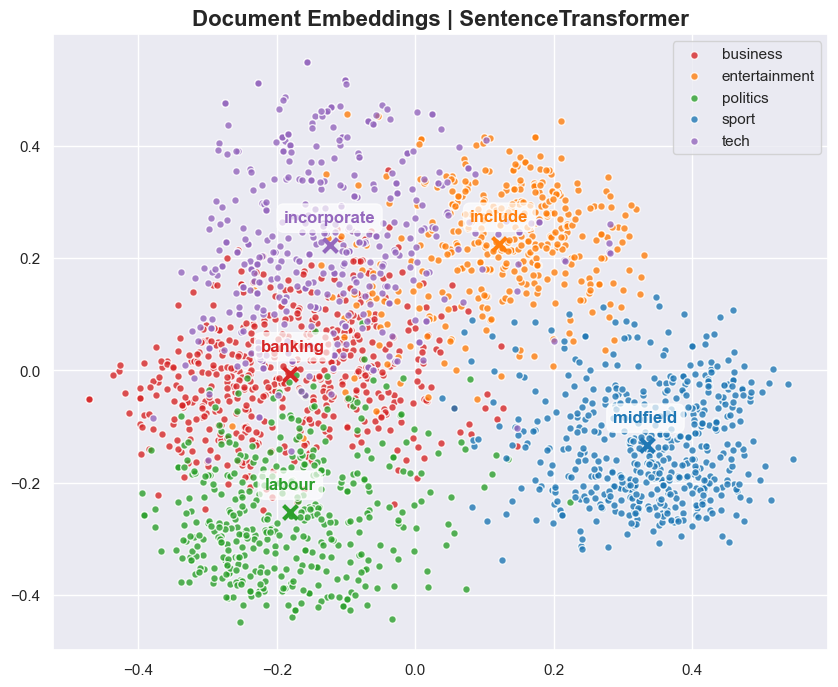

In [73]:
embeddings_df = pd.DataFrame(embedded_documents, columns=['x', 'y'])
embeddings_df['label'] = labels

plt.figure(figsize=(10, 8))

colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple']

for class_name, color in zip(transformer_model.defined_keywords.keys(), colors):
    x = embeddings_df[embeddings_df['label'] == class_name]['x']
    y = embeddings_df[embeddings_df['label'] == class_name]['y']

    plt.scatter(x, y, marker='o', s=30, c=color, label=class_name, linewidth=1, edgecolors='white', alpha=0.8)

# Plot the class center
for class_name, color in zip(transformer_model.defined_keywords.keys(), colors):
    plt.scatter(centered_documents_by_class[class_name][0], centered_documents_by_class[class_name][1], marker='x', s=100, c=color, linewidth=3)
    
    annotation_text = nearest_keywords_by_class[class_name]
    offset_x = len(annotation_text) * -0.006
    offset_y = 0.04
    plt.text(centered_documents_by_class[class_name][0] + offset_x, centered_documents_by_class[class_name][1] + offset_y, annotation_text, fontsize=12, color=color, fontweight='bold', backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='white', pad=0.4, alpha=0.7, boxstyle='round'))

plt.title('Document Embeddings | SentenceTransformer', fontsize=16, fontweight='bold')
plt.legend()

In [75]:
documents_df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

defined_keywords2 = { k: [v] for k, v in nearest_keywords_by_class.items() }
transformer2_model = DaCluDeK(defined_keywords=defined_keywords2, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True, dimensionality_reduction_n_components=2, dimensionality_reduction_model_name='PCA')
transformer2_model.fit()

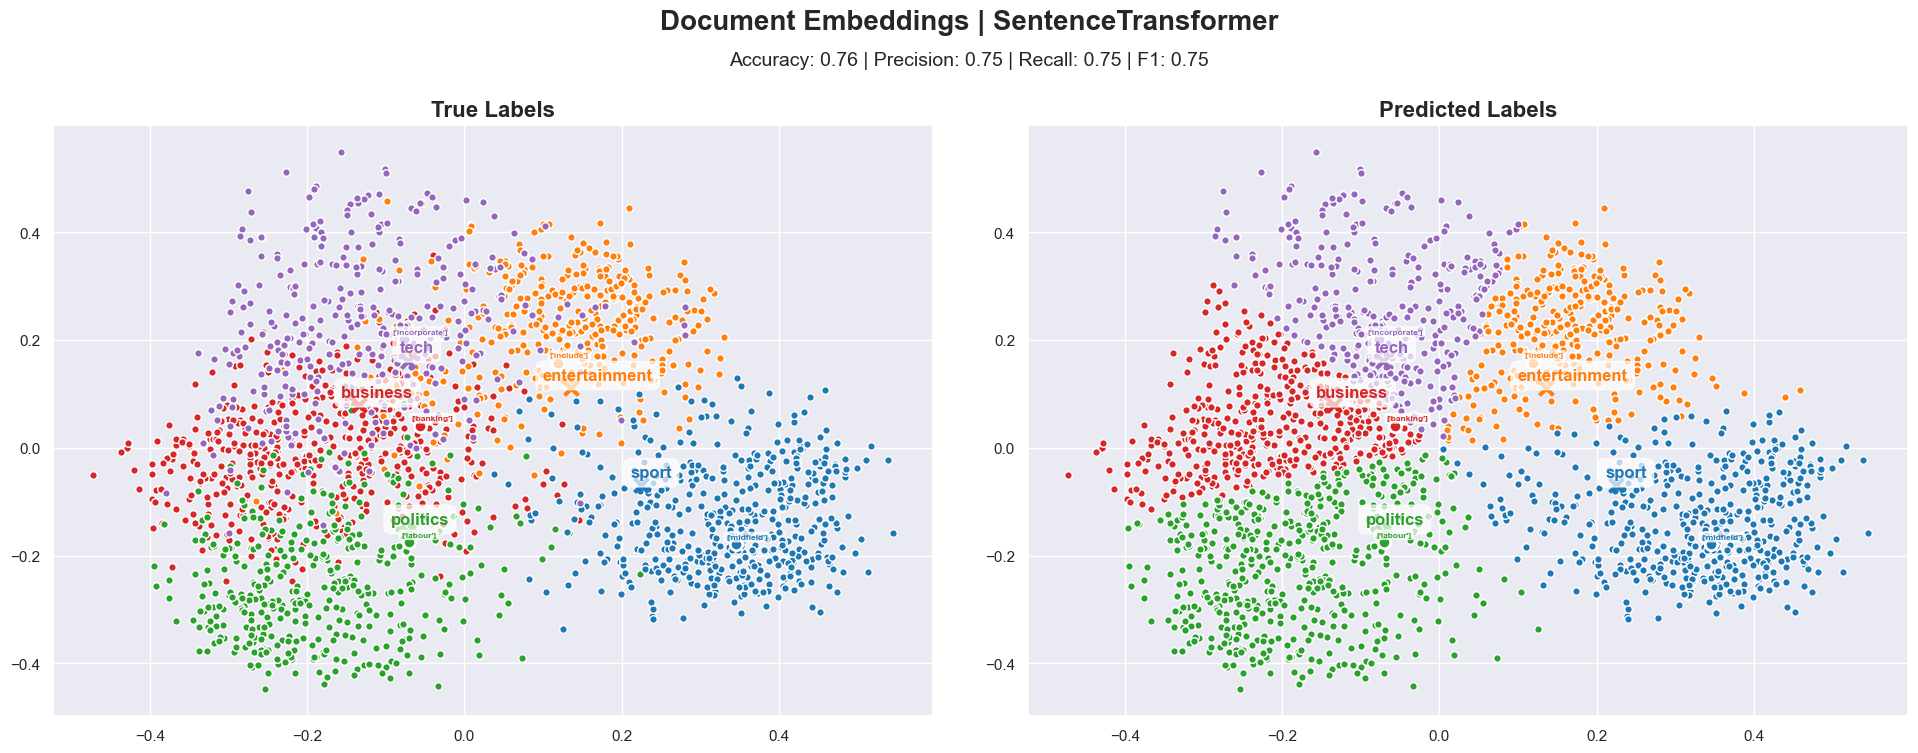

In [76]:
visualise_embeddings_for_model(transformer2_model)

In [79]:
documents_df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

transformer3_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True)
transformer3_model.fit()

embedded_documents, centered_documents_by_class, nearest_documents_by_class, nearest_keywords_by_class = get_centered_words_by_class(transformer3_model)

defined_keywords3 = { k: [v] for k, v in nearest_keywords_by_class.items() }
transformer3_model = DaCluDeK(defined_keywords=defined_keywords3, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True)
transformer3_model.fit()

In [80]:
transformer3_model.score(documents, labels)

,accuracy,f1,precision,recall
0,0.464719,0.4063,0.511343,0.500261
